In [1]:
%matplotlib inline

import os
import json
import numpy as np
import pickle
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt

from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.externals import joblib
from elasticsearch import Elasticsearch
from elasticsearch import helpers

#### Prepare articles for LDA

In [ ]:
ARTICLE_MAIN_DIR = "../wikiextractor/text/"

# contain raw articles / articles with metadata as json respectively
articles, articles_meta = list(), list()
for directory in os.listdir(ARTICLE_MAIN_DIR):
    for _file in os.listdir(ARTICLE_MAIN_DIR + directory): 
        with open("{}{}/{}".format(ARTICLE_MAIN_DIR, directory, _file)) as article_file:
            for line in article_file.readlines():
                article = json.loads(line)
                articles_meta.append(article)
                articles.append(article["text"])
print(len(articles))
        
tf_vectorizer = CountVectorizer(max_df=0.95, min_df=2, max_features=10000, stop_words='english')
tf = tf_vectorizer.fit_transform(articles)
tf_features = tf_vectorizer.get_feature_names()

In [29]:
feature_list = tf_vectorizer.get_feature_names()
joblib.dump(feature_list, 'vocabulary.pkl')

['vocabulary.pkl']

In [17]:
articles[0]

'Empiricism\n\nIn philosophy, empiricism is a theory that states that knowledge comes only or primarily from sensory experience. It is one of several views of epistemology, the study of human knowledge, along with rationalism and skepticism. Empiricism emphasises the role of empirical evidence in the formation of ideas, rather than innate ideas or traditions. However, empiricists may argue that traditions (or customs) arise due to relations of previous sense experiences.\n\nEmpiricism in the philosophy of science emphasises evidence, especially as discovered in experiments. It is a fundamental part of the scientific method that all hypotheses and theories must be tested against observations of the natural world rather than resting solely on "a priori" reasoning, intuition, or revelation.\n\nEmpiricism, often used by natural scientists, says that "knowledge is based on experience" and that "knowledge is tentative and probabilistic, subject to continued revision and falsification". Empir

In [15]:
# Run LDA
lda = LatentDirichletAllocation(n_components=25, max_iter=5, n_jobs = -1, 
                                learning_method='online', learning_offset=50.,random_state=0).fit(tf)

def display_topics(model, features, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic {}:".format(topic_idx))
        print(" ".join([features[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))

no_top_words = 10
display_topics(lda, tf_features, no_top_words)

Topic 0:
king england english son ireland queen henry edward century lord
Topic 1:
later years work time family wrote death father life died
Topic 2:
air used aircraft use engine speed space power design flight
Topic 3:
species water animals known large years plants sea dna fish
Topic 4:
war army military forces force battle attack british 000 troops
Topic 5:
energy used water light temperature high gas chemical mass earth
Topic 6:
island british new islands south sea north war american ships
Topic 7:
music album band song released new rock songs musical tour
Topic 8:
game team games season league player won players time world
Topic 9:
county city river area population state north west south park
Topic 10:
empire roman century emperor bc king ii kingdom dynasty al
Topic 11:
university international government world national economic country million school education
Topic 12:
party president states government state law united court election act
Topic 13:
church year pope calendar god ch

In [22]:
joblib.dump(lda, 'mylda.pkl') 

['mylda.pkl']

In [21]:
mlda = joblib.load("mylda.pkl")

#### Prepare articles for indexing
Calculate the topic distribution for each article and index the thing

In [59]:
to_index = articles_meta
for idx, doc in enumerate(tf):
    t_dist = mlda.transform(doc)
    for dist_key, dist_v in enumerate(t_dist.flatten()):
        to_index[idx]["topic_{}".format(dist_key)] = dist_v
    to_index[idx]["_id"] = str(idx)
    to_index[idx]['_index'] = 'topic_docs'
    to_index[idx]['_type'] =  'article'

In [63]:
with open("to_index.pkl", "wb") as ti:
    pickle.dump(to_index, ti)

#### Index the documents

In [5]:
with open("../to_index.pkl", "rb") as docs:
    to_index = pickle.load(docs)

In [3]:
to_index[0].keys()  

for doc in to_index:
    doc["topics"] = dict()
    for t in range(25):
        doc["topics"]["topic_{}".format(t)] = doc["topic_{}".format(t)]
        del doc["topic_{}".format(t)]

to_index[0]

{'_id': '0',
 '_index': 'topic_docs',
 '_type': 'article',
 'id': '10174',
 'text': 'Empiricism\n\nIn philosophy, empiricism is a theory that states that knowledge comes only or primarily from sensory experience. It is one of several views of epistemology, the study of human knowledge, along with rationalism and skepticism. Empiricism emphasises the role of empirical evidence in the formation of ideas, rather than innate ideas or traditions. However, empiricists may argue that traditions (or customs) arise due to relations of previous sense experiences.\n\nEmpiricism in the philosophy of science emphasises evidence, especially as discovered in experiments. It is a fundamental part of the scientific method that all hypotheses and theories must be tested against observations of the natural world rather than resting solely on "a priori" reasoning, intuition, or revelation.\n\nEmpiricism, often used by natural scientists, says that "knowledge is based on experience" and that "knowledge is 

In [ ]:
es = Elasticsearch()   


#helpers.bulk(es, to_index)

#### Create queries

Create queries to calculate a similarity score for the document of interest and the documents in our ES corpus
**Kullback-Leibler-Divergence** measures the difference in two probability distributions. Take the inverse to get a similarity score and add 1 to the denominator so that the score is still defined for `score(dist_A, dist_A)` and the division by 0 that would otherwise occur is avoided. This will distort the magnitudes of the scores, but should not alter the ordering of the scores.

In [37]:
# given the topic distribution
def query_distribution(dist):
    params = ['"topic_' + str(idx) + '": ' + str(val) for idx, val in enumerate(dist)]
    source = '"source": "return 1 / ('
    sources = ["params.topic_" + str(idx)  + "* Math.log(params.topic_" + str(idx) + 
               " / doc['topic_" + str(idx) + "'].value ) +" for idx, val in enumerate(dist)]
    query = '{ "query": { "function_score": { "query": { "match_all": { } }, "script_score" : { "script" : {' +  '"params": {' + ', '.join(params) + '},' + source + ' '.join(sources)[:-1] + ');"' + '}},"boost_mode": "replace"}}}'
    return(query)

### Can we speed up? 

### How are the topics distributed for the documents? 

In [8]:
with open("./to_index.pkl", "rb") as docs:
    processed_docs = joblib.load(docs)

In [10]:
df_docs = pd.DataFrame(processed_docs)
df_docs.head()

_id      _index    _type      id  \
0   0  topic_docs  article  185259   
1   1  topic_docs  article  185263   
2   2  topic_docs  article  185264   
3   3  topic_docs  article  185266   
4   4  topic_docs  article  185268   

                                                text  \
0  Germ theory of disease\n\nThe germ theory of d...   
1  Haloperidol\n\nHaloperidol, marketed under the...   
2  Star Wars Holiday Special\n\nThe Star Wars Hol...   
3  Fluphenazine\n\nFluphenazine, sold under the b...   
4  Typical antipsychotic\n\nTypical antipsychotic...   

                       title   topic_0   topic_1  topic_10  topic_11  ...  \
0     Germ theory of disease  0.000042  0.000042  0.134182  0.000042  ...   
1                Haloperidol  0.000075  0.000075  0.028348  0.000075  ...   
2  Star Wars Holiday Special  0.020450  0.000030  0.005773  0.007176  ...   
3               Fluphenazine  0.000235  0.000235  0.151531  0.016219  ...   
4      Typical antipsychotic  0.000127  0.000127  0.013222  0.009503  ...   

   topic_23  topic_24   topic_3   topic_4   topic_5   topic_6   topic_7  \
0  0.000042  0.000042  0.000042  0.000042  0.033910  0.010920  0.134268   
1  0.000075  0.000075  0.000075  0.000075  0.000075  0.000075  0.038117   
2  0.000030  0.000030  0.015790  0.001470  0.000030  0.001984  0.000030   
3  0.000235  0.000235  0.041033  0.000235  0.000235  0.000235  0.095015   
4  0.000127  0.000127  0.076595  0.000127  0.000127  0.000127  0.114780   

    topic_8   topic_9                                         url  
0  0.454824  0.000042  https://en.wikipedia.org/wiki?curid=185259  
1  0.906197  0.000075  https://en.wikipedia.org/wiki?curid=185263  
2  0.000030  0.041910  https://en.wikipedia.org/wiki?curid=185264  
3  0.651472  0.000235  https://en.wikipedia.org/wiki?curid=185266  
4  0.769710  0.000127  https://en.wikipedia.org/wiki?curid=185268  

[5 rows x 32 columns]

In [11]:
# add the percentage of the nr. 1 topic as an extra column
topic_columns = ["topic_{}".format(i) for i in range(25)]

df_docs["max_topic_perc"] = df_docs[topic_columns].max(axis=1)
df_docs.head()

_id      _index    _type      id  \
0   0  topic_docs  article  185259   
1   1  topic_docs  article  185263   
2   2  topic_docs  article  185264   
3   3  topic_docs  article  185266   
4   4  topic_docs  article  185268   

                                                text  \
0  Germ theory of disease\n\nThe germ theory of d...   
1  Haloperidol\n\nHaloperidol, marketed under the...   
2  Star Wars Holiday Special\n\nThe Star Wars Hol...   
3  Fluphenazine\n\nFluphenazine, sold under the b...   
4  Typical antipsychotic\n\nTypical antipsychotic...   

                       title   topic_0   topic_1  topic_10  topic_11  ...  \
0     Germ theory of disease  0.000042  0.000042  0.134182  0.000042  ...   
1                Haloperidol  0.000075  0.000075  0.028348  0.000075  ...   
2  Star Wars Holiday Special  0.020450  0.000030  0.005773  0.007176  ...   
3               Fluphenazine  0.000235  0.000235  0.151531  0.016219  ...   
4      Typical antipsychotic  0.000127  0.000127  0.013222  0.009503  ...   

   topic_24   topic_3   topic_4   topic_5   topic_6   topic_7   topic_8  \
0  0.000042  0.000042  0.000042  0.033910  0.010920  0.134268  0.454824   
1  0.000075  0.000075  0.000075  0.000075  0.000075  0.038117  0.906197   
2  0.000030  0.015790  0.001470  0.000030  0.001984  0.000030  0.000030   
3  0.000235  0.041033  0.000235  0.000235  0.000235  0.095015  0.651472   
4  0.000127  0.076595  0.000127  0.000127  0.000127  0.114780  0.769710   

    topic_9                                         url  max_topic_perc  
0  0.000042  https://en.wikipedia.org/wiki?curid=185259        0.454824  
1  0.000075  https://en.wikipedia.org/wiki?curid=185263        0.906197  
2  0.041910  https://en.wikipedia.org/wiki?curid=185264        0.644053  
3  0.000235  https://en.wikipedia.org/wiki?curid=185266        0.651472  
4  0.000127  https://en.wikipedia.org/wiki?curid=185268        0.769710  

[5 rows x 33 columns]

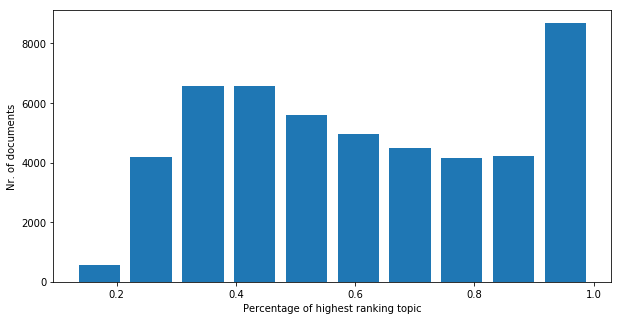

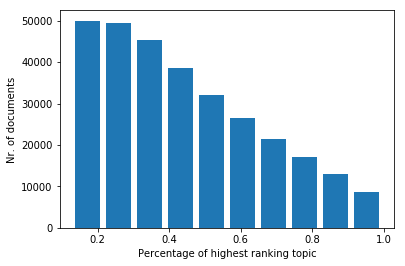

In [12]:
fig, ax = plt.subplots(figsize=(10,5))
plt.hist(x=df_docs["max_topic_perc"], bins=10, rwidth=0.8)
plt.xlabel("Percentage of highest ranking topic")
plt.ylabel("Nr. of documents")
plt.show()
fig.savefig("./percentage_highest_topic.png")  

plt.hist(x=df_docs["max_topic_perc"], bins=10, rwidth=0.8, cumulative=-1)
plt.xlabel("Percentage of highest ranking topic")
plt.ylabel("Nr. of documents")
plt.show()

In [ ]:
df_docs

#### What about the median? 

In [16]:
df_docs["median_topic_perc"] = df_docs[topic_columns].median(axis=1)
df_docs.head(100)

_id      _index    _type      id  \
0    0  topic_docs  article  185259   
1    1  topic_docs  article  185263   
2    2  topic_docs  article  185264   
3    3  topic_docs  article  185266   
4    4  topic_docs  article  185268   
5    5  topic_docs  article  185271   
6    6  topic_docs  article  185272   
7    7  topic_docs  article  185273   
8    8  topic_docs  article  185274   
9    9  topic_docs  article  185275   
10  10  topic_docs  article  185276   
11  11  topic_docs  article  185284   
12  12  topic_docs  article  185289   
13  13  topic_docs  article  185290   
14  14  topic_docs  article  185300   
15  15  topic_docs  article  185306   
16  16  topic_docs  article  185307   
17  17  topic_docs  article  185311   
18  18  topic_docs  article  185313   
19  19  topic_docs  article  185318   
20  20  topic_docs  article  185319   
21  21  topic_docs  article  185320   
22  22  topic_docs  article  185323   
23  23  topic_docs  article  185324   
24  24  topic_docs  article  185325   
25  25  topic_docs  article  185330   
26  26  topic_docs  article  185333   
27  27  topic_docs  article  185337   
28  28  topic_docs  article  185338   
29  29  topic_docs  article  185339   
..  ..         ...      ...     ...   
70  70  topic_docs  article  185514   
71  71  topic_docs  article  185515   
72  72  topic_docs  article  185517   
73  73  topic_docs  article  185519   
74  74  topic_docs  article  185520   
75  75  topic_docs  article  185528   
76  76  topic_docs  article  185529   
77  77  topic_docs  article  185536   
78  78  topic_docs  article  185537   
79  79  topic_docs  article  185538   
80  80  topic_docs  article  185542   
81  81  topic_docs  article  185544   
82  82  topic_docs  article  185546   
83  83  topic_docs  article  185560   
84  84  topic_docs  article  185564   
85  85  topic_docs  article  185569   
86  86  topic_docs  article  185576   
87  87  topic_docs  article  185586   
88  88  topic_docs  article  185589   
89  89  topic_docs  article  185590   
90  90  topic_docs  article  185604   
91  91  topic_docs  article  185613   
92  92  topic_docs  article  185614   
93  93  topic_docs  article  185615   
94  94  topic_docs  article  170512   
95  95  topic_docs  article  170514   
96  96  topic_docs  article  170516   
97  97  topic_docs  article  170517   
98  98  topic_docs  article  170518   
99  99  topic_docs  article  170521   

                                                 text  \
0   Germ theory of disease\n\nThe germ theory of d...   
1   Haloperidol\n\nHaloperidol, marketed under the...   
2   Star Wars Holiday Special\n\nThe Star Wars Hol...   
3   Fluphenazine\n\nFluphenazine, sold under the b...   
4   Typical antipsychotic\n\nTypical antipsychotic...   
5   Polyiamond\n\nA polyiamond (also polyamond or ...   
6   Atypical antipsychotic\n\nThe atypical antipsy...   
7   Eurovision Song Contest 1987\n\nThe Eurovision...   
8   Eurovision Song Contest 1986\n\nThe Eurovision...   
9   Partita\n\nPartita (also "partie", "partia", "...   
10  Eurovision Song Contest 1985\n\nThe Eurovision...   
11  Moon Mullins\n\nMoon Mullins is an American co...   
12  The Silver Chalice\n\nThe Silver Chalice is a ...   
13  Mars effect\n\nThe Mars effect is a purported ...   
14  Barnaby (comics)\n\nBarnaby was a comic strip ...   
15  Beetle Bailey\n\nBeetle Bailey (begun on Septe...   
16  Magical thinking\n\nMagical thinking is a term...   
17  United States presidential primary\n\nThe pres...   
18  Freeganism\n\nFreeganism is a practice and ide...   
19  Brown Bess\n\n"Brown Bess" is a nickname of un...   
20  Charleville musket\n\nThe Charleville musket w...   
21  Homeric Hymns\n\nThe Homeric Hymns (, "Homērik...   
22  Joe Palooka\n\nJoe Palooka is an American comi...   
23  Musket\n\nA musket is a muzzle-loaded long gun...   
24  Coining (metalworking)\n\nCoining is a form of...   
25  Julius Knipl, Real Estate Photographer\n\nJuli...   
26  Huntley Gordon\n\nHuntley Ashworth Gordon

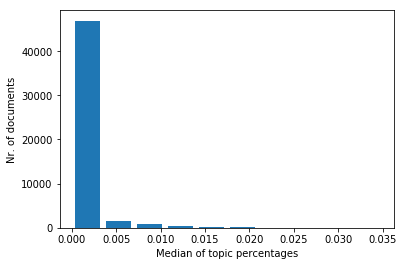

In [17]:
plt.hist(x=df_docs["median_topic_perc"], bins=10, rwidth=0.8)
plt.xlabel("Median of topic percentages")
plt.ylabel("Nr. of documents")
plt.show()


#### How many topics can we exclude by setting a threshold?

In [18]:
thresholds = np.arange(0.005, 0.1, 0.005)

for t in thresholds:
    percentage_to_exclude = df_docs[df_docs["topic_0"] < t].shape[0] / df_docs.shape[0] * 100
    print("Threshold {}; exclude: {} percent".format(t, percentage_to_exclude))

Threshold 0.005; exclude: 81.19 percent
Threshold 0.01; exclude: 85.10600000000001 percent
Threshold 0.015; exclude: 87.71600000000001 percent
Threshold 0.02; exclude: 89.67399999999999 percent
Threshold 0.025; exclude: 91.174 percent
Threshold 0.030000000000000002; exclude: 92.22200000000001 percent
Threshold 0.034999999999999996; exclude: 93.08800000000001 percent
Threshold 0.04; exclude: 93.78999999999999 percent
Threshold 0.045; exclude: 94.27600000000001 percent
Threshold 0.049999999999999996; exclude: 94.756 percent
Threshold 0.055; exclude: 95.182 percent
Threshold 0.06; exclude: 95.532 percent
Threshold 0.065; exclude: 95.848 percent
Threshold 0.07; exclude: 96.096 percent
Threshold 0.07500000000000001; exclude: 96.344 percent
Threshold 0.08; exclude: 96.526 percent
Threshold 0.085; exclude: 96.712 percent
Threshold 0.09000000000000001; exclude: 96.87400000000001 percent
Threshold 0.095; exclude: 97.038 percent


This means that we can exclude ~85 percent of topics if we set a threshold of 5 percent for topic 0. As we have seen above: the maximum topic will usually be ranked at around ~30 percent! So by just excluding the ones that don't have at least 5% for that topic (in case of topic_0) we can prefilter 85% where we dont have to calculate the KL-score!

In [21]:
df_docs[df_docs["topic_0"] > 0.3].shape

(378, 34)

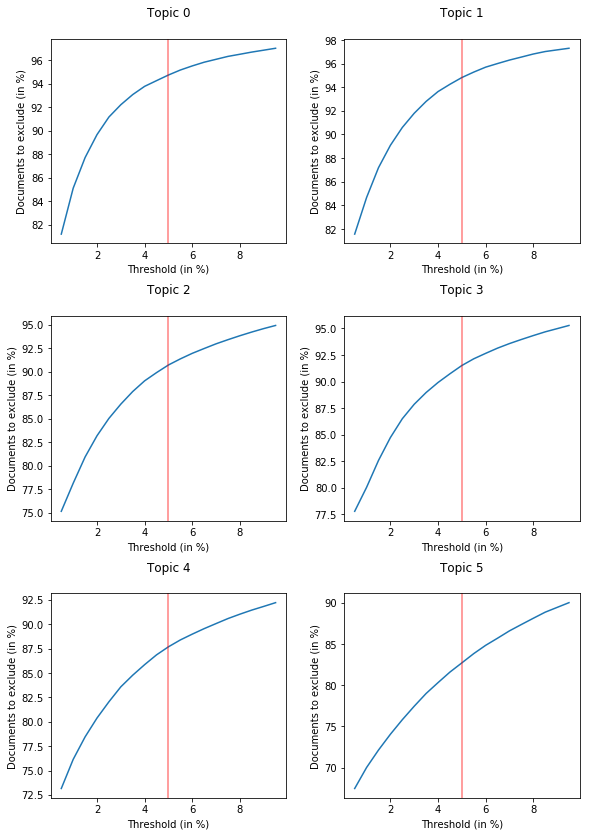

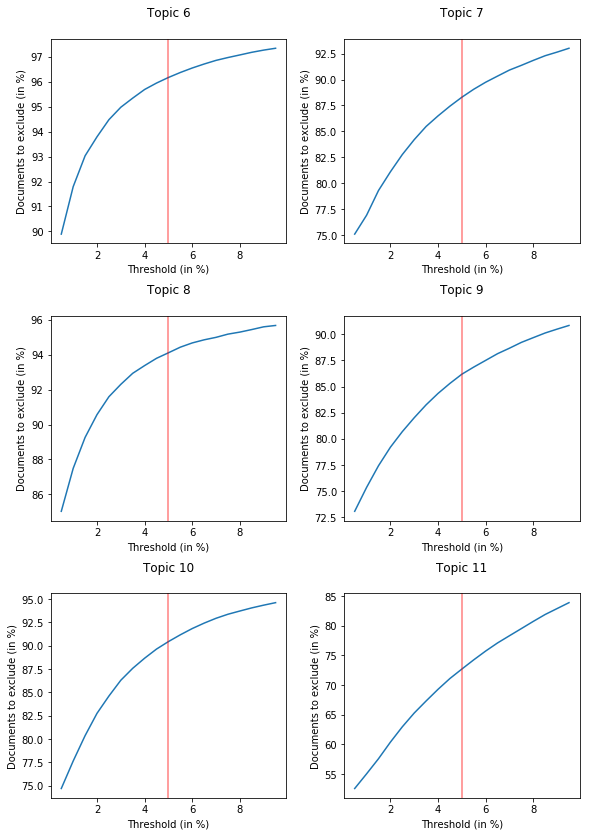

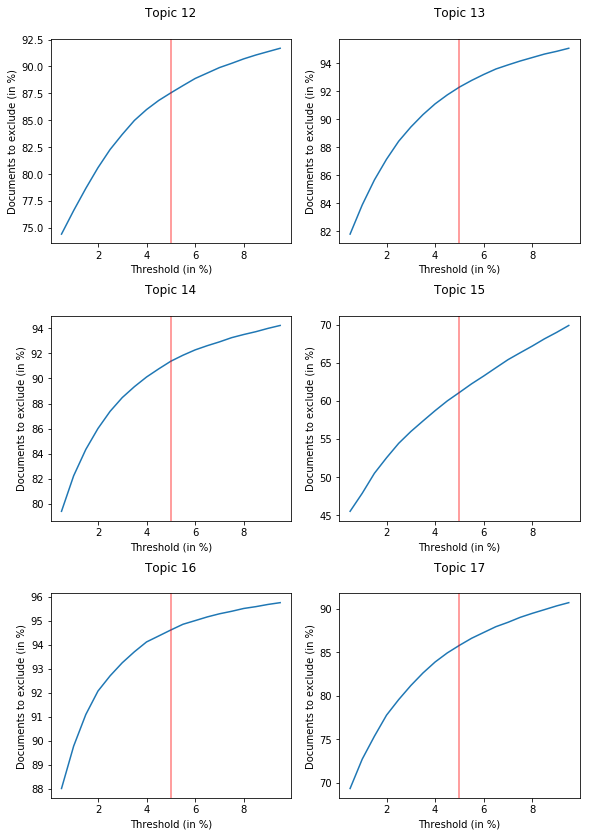

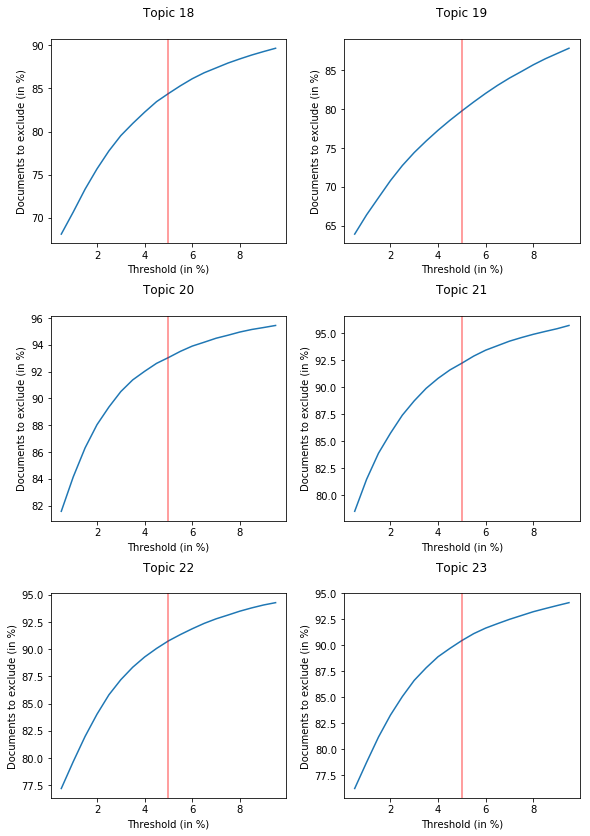

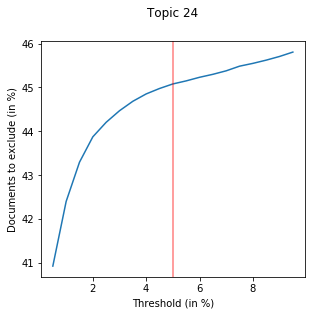

In [23]:
for r in range(0, 25, 6):
    fig = plt.figure(figsize=[8.3, 11.7])
    for i, topic_column in enumerate(topic_columns[r:r+6]):
        fig.add_subplot(3,2,int(i+1))
        x_vals, y_vals = list(), list()
        for t in thresholds:
            percentage_to_exclude = df_docs[df_docs[topic_column] < t].shape[0] / df_docs.shape[0] * 100
            x_vals.append(t*100)
            y_vals.append(percentage_to_exclude)
        plt.plot(x_vals, y_vals)
        plt.axvline(x=5, color="red", alpha=0.5)
        plt.title("Topic {}".format(r+i), y=1.08)
        plt.xlabel("Threshold (in %)")
        plt.ylabel("Documents to exclude (in %)")
    fig.tight_layout()
    fig.savefig("./figures/excluded_docs_by_threshold_{}_{}.pdf".format(r, r+5))

In [3]:
x2 = [0.1,1.1,2.1,3.1,4.1]
x1 = [-0.1,0.9,1.9,2.9,3.9]
y1 = [0.6, 0.1, 0.1, 0.1, 0.1]
y2 = [0.2]*5

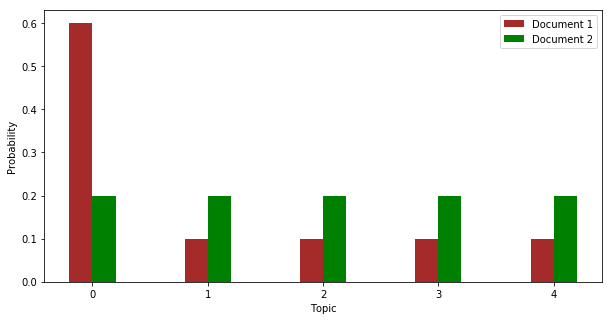

In [6]:
fig, ax = plt.subplots(figsize=(10,5))
width = 0.2
ax.bar(x1, y1, width, alpha=1, label='Document 1', align="center", color="brown")
ax.bar(x2, y2, width, alpha=1, label='Document 2', align="center", color="green")
ax.set_xticks(range(0, 5))
ax.set_xlabel('Topic')
ax.set_ylabel('Probability')
ax.legend(loc='upper right')
plt.show()
fig.savefig("./figures/KL_example_topic_docs.png")

In [37]:
def kl_div(p, q):
    return p @ np.log(p/q)

In [38]:
p = np.array([0.6,0.1,0.1,0.1,0.1])
q = np.array([0.2,0.2,0.2,0.2,0.2])
print("KL(P,Q): {}".format(kl_div(p, q)))
print("KL(Q,P): {}".format(kl_div(q, p)))

KL(P,Q): 0.38190850097688755
KL(Q,P): 0.3347952867143343
